# GloVe vectors with Gensim (after training on Reuters)

This notebook shows how to **load and query** the GloVe vectors you trained (from the *from-scratch* notebook) using **Gensim**.

**Prerequisite:** Run `03 - GloVe from Scratch (Reuters + Dynamic Window + Export).ipynb` first to generate `reuters_glove_vectors.txt`.

**Dataset credit:** Reuters-21578 corpus as packaged by NLTK (`nltk.corpus.reuters`).


In [1]:
from gensim.models import KeyedVectors

VEC_PATH = 'reuters_glove_vectors.txt'  # must match the export cell output
kv = KeyedVectors.load_word2vec_format(VEC_PATH, binary=False)
print('Loaded:', len(kv), 'dim=', kv.vector_size)


Loaded: 12480 dim= 2


In [2]:
# Sanity check: vector shape for a frequent word
w = 'market' if 'market' in kv else kv.index_to_key[0]
print(w, kv[w].shape)


market (2,)


## Similarity queries

If a query word is **OOV** (out of vocabulary), Reuters-trained vectors may not include it (or it may have been filtered out during vocab construction).


In [4]:
queries = ['obama', 'coke', 'banana', 'language', 'plant']

for q in queries:
    print('Query:', q)
    try:
        print(kv.most_similar(q, topn=10))
    except KeyError as e:
        print('OOV:', e)


Query: obama
OOV: "Key 'obama' not present in vocabulary"
Query: coke
OOV: "Key 'coke' not present in vocabulary"
Query: banana
OOV: "Key 'banana' not present in vocabulary"
Query: language
[('sullivan', 1.0), ('sustaining', 0.9999999403953552), ('depth', 0.9999997615814209), ('steeper', 0.9999997615814209), ('mo', 0.9999997019767761), ('contributing', 0.9999997019767761), ('senior', 0.999999463558197), ('site', 0.9999988675117493), ('pushes', 0.9999986290931702), ('amalgamation', 0.9999982714653015)]
Query: plant
[('treaty', 0.9999998807907104), ('margaret', 0.999999463558197), ('confused', 0.9999989867210388), ('usuaually', 0.9999983310699463), ('explicitly', 0.9999977946281433), ('sterling', 0.9999974966049194), ('discovery', 0.9999967217445374), ('voluntarily', 0.999996542930603), ('dipping', 0.9999959468841553), ('reps', 0.9999958872795105)]


## Analogy

Solve: **a : b :: c : ?** using vector arithmetic.


In [6]:
def analogy(a, b, c, topn=10):
    """Solve: a is to b as c is to ?"""
    for w in (a, b, c):
        if w not in kv:
            print(f'OOV in analogy: {w}')
            return None
    print(f"Analogy: {a} : {b} :: {c} : ?")
    return kv.most_similar(positive=[b, c], negative=[a], topn=topn)

print(analogy('woman', 'king', 'man'))
print(analogy('japan', 'sushi', 'italy'))


OOV in analogy: woman
None
Analogy: japan : sushi :: italy : ?
[('unavoidable', 1.0), ('freedman', 0.9999998807907104), ('advocated', 0.9999995231628418), ('chyn', 0.9999991059303284), ('interferes', 0.999998927116394), ('installs', 0.9999988079071045), ('aggregate', 0.9999974370002747), ('proximity', 0.999997079372406), ('deprive', 0.9999959468841553), ('constitucion', 0.9999944567680359)]


## Cosine distance (1 - cosine similarity)

Smaller distance => more similar.


In [7]:
def safe_distance(w1, w2):
    if w1 not in kv or w2 not in kv:
        missing = [w for w in (w1, w2) if w not in kv]
        print('OOV:', missing)
        return None
    return kv.distance(w1, w2)

pairs = [('dog', 'cat'), ('dog', 'fruit'), ('happy', 'cheerful'), ('happy', 'sad')]
for w1, w2 in pairs:
    print((w1, w2), 'distance =', safe_distance(w1, w2))


OOV: ['dog', 'cat']
('dog', 'cat') distance = None
OOV: ['dog']
('dog', 'fruit') distance = None
OOV: ['cheerful']
('happy', 'cheerful') distance = None
('happy', 'sad') distance = 0.22750807


## Doesn't match

Find the word that doesn't belong in a list.


In [8]:
try:
    print(kv.doesnt_match('coke pepsi sprite water'.split()))
except KeyError as e:
    print('OOV:', e)


water


## Visualization (PCA)

We filter out OOV words so this cell doesn't crash.


In vocab: 20 OOV: 25
Sample OOV: ['brandy', 'rum', 'champagne', 'spaghetti', 'borscht', 'hamburger', 'falafel', 'meatballs', 'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard', 'frog', 'toad', 'ape', 'kangaroo', 'wombat']


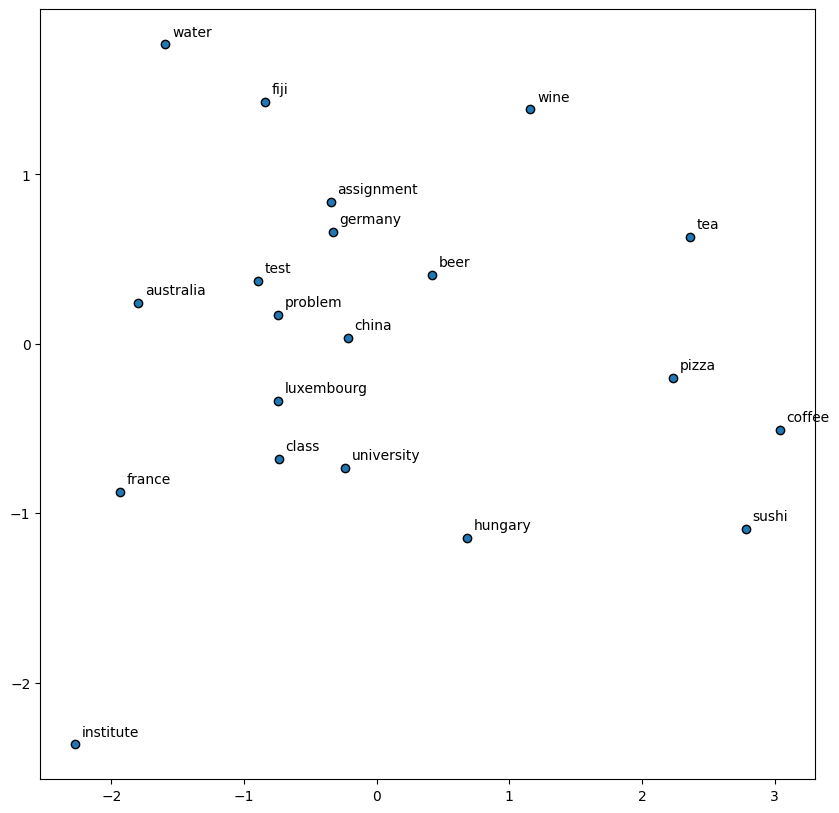

In [9]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

words = ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
        'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
        'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
        'frog', 'toad', 'ape', 'kangaroo', 'wombat', 'wolf',
        'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
        'homework', 'assignment', 'problem', 'exam', 'test', 'class',
        'school', 'college', 'university', 'institute']

in_vocab = [w for w in words if w in kv]
oov = [w for w in words if w not in kv]
print('In vocab:', len(in_vocab), 'OOV:', len(oov))
if oov:
    print('Sample OOV:', oov[:20])

word_vectors = np.array([kv[w] for w in in_vocab])
twodim = PCA().fit_transform(word_vectors)[:, :2]

plt.figure(figsize=(10, 10))
plt.scatter(twodim[:, 0], twodim[:, 1], edgecolors='k')
for word, (x, y) in zip(in_vocab, twodim):
    plt.text(x + 0.05, y + 0.05, word)
plt.show()
